<a href="https://colab.research.google.com/github/carlomagnani/Stock-Price-Forecaster/blob/main/SP500_Trend_Forecast_2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np

print("Tensorflow version: "+tf.__version__)

#! pip install pmdarima

# Google file system
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler

drive.mount('/GoogleDrive', force_remount=True)

import math

file =   "/GoogleDrive/My Drive/S&P.xlsx"
dataset = pd.read_excel(file, sheet_name="ts")

Tensorflow version: 2.8.0
Mounted at /GoogleDrive


In [2]:
#Date to Datetime for Plotting
dataset['date'] = pd.to_datetime(dataset['date'])

#Returns
dataset['log_value'] = np.log(dataset['time'])
dataset['log_ret'] = dataset['log_value'] - dataset['log_value'].shift(+1)
dataset['lead_ret'] = dataset['log_ret'].shift(-1)
dataset['lead_weekly_ret'] = dataset['log_ret'].rolling(5).sum().shift(-5)
dataset['lag_weekly_ret'] = dataset['log_ret'].rolling(5).sum()

#Returns Classes
dataset['log_ret_class'] = np.where(dataset['log_ret']>0,1,0) #Log Return Class
dataset['lag_weekly_ret_class'] = np.where(dataset['lag_weekly_ret']>0,1,0) #T to T-5 Return Class
dataset['lead_weekly_ret_class'] = np.where(dataset['lead_weekly_ret']> 0, 1, 0) #Target Class
dataset['lead_ret_class'] = np.where(dataset['lead_ret']> 0, 1, 0) #Next Day Return Class

#Simple Moving Averages
dataset['sma_3'] = dataset['log_value'].rolling(3).mean()
dataset['sma_5'] = dataset['log_value'].rolling(5).mean()
dataset['sma_10'] = dataset['log_value'].rolling(10).mean()
dataset['sma_20'] = dataset['log_value'].rolling(20).mean()
dataset['sma_50'] = dataset['log_value'].rolling(50).mean()
dataset['sma_100'] = dataset['log_value'].rolling(100).mean()
dataset['sma_200'] = dataset['log_value'].rolling(200).mean()

#Exponentially Weighted Variance 
dataset['sq_ret'] = np.power(dataset['log_ret'],2)
dataset['ewma_var'] = dataset['sq_ret'].ewm(alpha = 0.96).mean() #Uses the RiskMetrics 0.96 decay factor

#Exponentially Weighted Moving Averages
dataset['ema_200'] = dataset['log_value'].ewm(alpha = 0.01).mean()
dataset['ema_50'] = dataset['log_value'].ewm(alpha = 0.0392).mean()
dataset['ema_10'] = dataset['log_value'].ewm(alpha = 0.181).mean()
dataset['ema_3'] = dataset['log_value'].ewm(alpha = 0.5).mean()

#Drop Time and NAs
dataset.pop('time')

dataset.dropna(inplace = True)

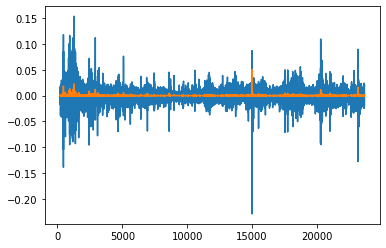

In [ ]:
#Some Plotting to check variables
#plt.plot(dataset['log_value'])
#plt.plot(dataset['ma_3'])
#plt.plot(dataset['ma_20'])
plt.plot(dataset['log_ret'])
plt.plot(dataset['ewma_var'])

In [3]:
#Signal Generation

#Momentum Rule
dataset['momentum_120'] = dataset['log_value'] - dataset['log_value'].shift(+200)
dataset['momentum_121'] = dataset['log_value'].shift(+20) - dataset['log_value'].shift(+200)
dataset['momentum_61'] = dataset['log_value'].shift(+20) - dataset['log_value'].shift(+100)

dataset['mom_120_rule'] = np.where(dataset['momentum_120']> 0, 1, 0)
dataset['mom_121_rule'] = np.where(dataset['momentum_121']> 0, 1, 0)
dataset['mom_61_rule'] = np.where(dataset['momentum_61']> 0, 1, 0)

#MA Change of Direction Rule

dataset['ma_200_cd_rule'] = np.where((dataset['sma_200']- dataset['sma_200'].shift(+1))>0,1,0)
dataset['ma_20_cd_rule'] = np.where((dataset['sma_20']- dataset['sma_20'].shift(+1))>0,1,0)

#PMA Rule

dataset['pma_20'] = dataset['log_value'] - dataset['sma_20']      
dataset['pma_100'] = dataset['log_value'] - dataset['sma_100']
dataset['pma_200'] = dataset['log_value'] - dataset['sma_200']

dataset['pma_20_rule'] = np.where(dataset['pma_20']>0, 1, 0)
dataset['pma_100_rule'] = np.where(dataset['pma_100']>0, 1, 0)
dataset['pma_200_rule'] = np.where(dataset['pma_200']>0, 1, 0)

#MA Crossover Rule

dataset['mac_3_10'] = dataset['sma_3'] - dataset['sma_10']
dataset['mac_50_200'] = dataset['sma_50'] - dataset['sma_200']

dataset['mac_3_10_rule'] = np.where(dataset['mac_3_10']>0, 1, 0)
dataset['mac_50_200_rule'] = np.where(dataset['mac_50_200']>0, 1, 0)

#Ma Convergence/Divergence Rule

dataset['mac_ema_50_200'] = dataset['ema_50'] - dataset['ema_200']

dataset['ema_mac_50_200'] = dataset['mac_ema_50_200'].ewm(alpha = 0.095).mean()

dataset['macd_50_200'] = dataset['mac_ema_50_200'] - dataset['ema_mac_50_200']

dataset['macd_50_200_rule'] = np.where(dataset['macd_50_200']>0, 1, 0)

In [4]:
rule_cols = [col for col in dataset.columns if 'rule' in col]

col_names = ['log_ret_class', 'lag_weekly_ret_class', 'ewma_var']

var_name = ['lead_weekly_ret_class']

col_names =  var_name + col_names + rule_cols

#var_name = ['lead_weekly_ret_class']

print(col_names)

model_df = dataset[col_names]

model_df.dropna(inplace = True)

model_df


['lead_weekly_ret_class', 'log_ret_class', 'lag_weekly_ret_class', 'ewma_var', 'mom_120_rule', 'mom_121_rule', 'mom_61_rule', 'ma_200_cd_rule', 'ma_20_cd_rule', 'pma_20_rule', 'pma_100_rule', 'pma_200_rule', 'mac_3_10_rule', 'mac_50_200_rule', 'macd_50_200_rule']


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,lead_weekly_ret_class,log_ret_class,lag_weekly_ret_class,ewma_var,mom_120_rule,mom_121_rule,mom_61_rule,ma_200_cd_rule,ma_20_cd_rule,pma_20_rule,pma_100_rule,pma_200_rule,mac_3_10_rule,mac_50_200_rule,macd_50_200_rule
199,1,1,1,0.000012,0,0,0,0,0,1,1,1,1,1,0
200,1,1,1,0.000010,0,0,0,1,1,1,1,1,1,1,1
201,1,1,1,0.000005,0,0,0,1,1,1,1,1,1,1,1
202,0,1,1,0.000029,0,0,0,1,1,1,1,1,1,1,1
203,1,0,1,0.000046,0,0,0,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23652,0,1,1,0.000479,1,1,1,1,1,0,0,0,0,1,0
23653,0,0,1,0.000025,1,1,1,1,0,0,0,0,0,1,0
23654,0,0,1,0.000234,1,1,1,1,0,0,0,0,0,1,0
23655,0,1,1,0.000337,1,1,1,1,0,0,0,0,1,1,0


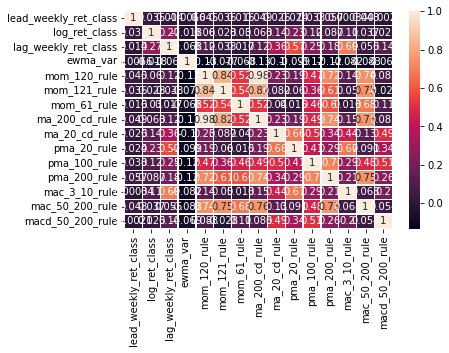

In [ ]:
#Correlation Matrix

import seaborn as sn

corr_mat = model_df.corr()
sn.heatmap(corr_mat, annot=True, linewidths=.3)
plt.show()

In [5]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

#prepare Train-Test-Validate Dataset

steps = 100

values = model_df.values

# Creating a data structure with i time-steps and 1 output
X = []
y = []

for i in range(steps, len(values)):
    X.append(values[i-steps:i, 1:])
    y.append(values[i, 0])

X, y = np.array(X), np.array(y)

X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

y = np.reshape(y, (y.shape[0],1))

# Creating a data structure with i time-steps and 1 output
train_X = []
train_y = []

test_X = []
test_y = []

validation_X = []
validation_y = []

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)

train_X, validation_X, train_y, validation_y = train_test_split(train_X, train_y, test_size=0.02, random_state=1) # 0.02 x 0.8 = 0.016

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, validation_X.shape, validation_y.shape)

(18312, 100, 14) (18312, 1) (4672, 100, 14) (4672, 1) (374, 100, 14) (374, 1)


In [ ]:
train_y

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

Epoch 1/100
573/573 - 241s - loss: 0.6871 - accuracy: 0.5572 - val_loss: 0.6850 - val_accuracy: 0.5610 - 241s/epoch - 420ms/step
Epoch 2/100
573/573 - 150s - loss: 0.6851 - accuracy: 0.5624 - val_loss: 0.6849 - val_accuracy: 0.5597 - 150s/epoch - 262ms/step
Epoch 3/100
573/573 - 150s - loss: 0.6841 - accuracy: 0.5635 - val_loss: 0.6848 - val_accuracy: 0.5591 - 150s/epoch - 262ms/step
Epoch 4/100
573/573 - 150s - loss: 0.6839 - accuracy: 0.5666 - val_loss: 0.6848 - val_accuracy: 0.5569 - 150s/epoch - 261ms/step
Epoch 5/100
573/573 - 149s - loss: 0.6824 - accuracy: 0.5679 - val_loss: 0.6840 - val_accuracy: 0.5584 - 149s/epoch - 260ms/step
Epoch 6/100
573/573 - 150s - loss: 0.6812 - accuracy: 0.5702 - val_loss: 0.6831 - val_accuracy: 0.5629 - 150s/epoch - 262ms/step
Epoch 7/100
573/573 - 150s - loss: 0.6790 - accuracy: 0.5777 - val_loss: 0.6813 - val_accuracy: 0.5642 - 150s/epoch - 261ms/step
Epoch 8/100
573/573 - 149s - loss: 0.6775 - accuracy: 0.5771 - val_loss: 0.6801 - val_accuracy: 0

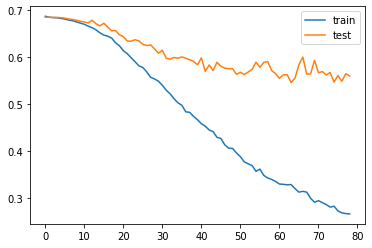

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience = 15, min_delta=0.001)

model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))

#Additional layers we researched and then didn't use due to poor performance
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(units = 1, activation = 'sigmoid'))

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [tf.keras.metrics.Recall()])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = 'accuracy')
# fit network
history = model.fit(train_X, train_y, epochs = 100, batch_size=32, validation_data = (test_X, test_y), verbose=2, shuffle=False, callbacks=[early_stopping])

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

yhat = (model.predict(validation_X) > 0.5).astype("int32")

yhat = yhat.reshape(yhat.shape[0],yhat.shape[1])

validation_y = validation_y.reshape(validation_y.shape[0],1)

print(confusion_matrix(pd.DataFrame(validation_y).iloc[:,0], pd.DataFrame(yhat).iloc[:,0]))
#print('Classification Report')
#target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(pd.DataFrame(validation_y).iloc[:,0], pd.DataFrame(yhat).iloc[:,0], target_names = ['0', '1']))

#print(yhat, validation_y)

[[119  41]
 [ 43 171]]
              precision    recall  f1-score   support

           0       0.73      0.74      0.74       160
           1       0.81      0.80      0.80       214

    accuracy                           0.78       374
   macro avg       0.77      0.77      0.77       374
weighted avg       0.78      0.78      0.78       374



In [8]:
#Import Random Forest and Train_Test Split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

train_rf_X = train_X[:,0,1:]

test_rf_X = test_X[:,0,1:]

train_rf_y = train_X[:,0,0]

test_rf_y = test_X[:,0,0]

#validation_rf_X = validation_X[:,0,1:]

#validation_rf_y = validation_y[:,0,0]

print(train_rf_X.shape, train_rf_y.shape, test_rf_X.shape, test_rf_y.shape)

#, test_rf_X, train_rf_y, test_rf_y = 

#Create a Gaussian Classifier
clf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(train_rf_X,train_rf_y)

y_pred = clf.predict(test_rf_X)

#y_val = clf.predict(validation_rf_X)

from sklearn import metrics

#test metrics

print(confusion_matrix(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_pred).iloc[:,0]))

print(classification_report(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_pred).iloc[:,0], target_names = ['0', '1']))

#validation metrics
#print(confusion_matrix(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(y_val).iloc[:,0]))

#print(classification_report(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(y_val).iloc[:,0], target_names = ['0', '1']))


(18312, 13) (18312,) (4672, 13) (4672,)
[[1155 1072]
 [ 816 1629]]
              precision    recall  f1-score   support

           0       0.59      0.52      0.55      2227
           1       0.60      0.67      0.63      2445

    accuracy                           0.60      4672
   macro avg       0.59      0.59      0.59      4672
weighted avg       0.59      0.60      0.59      4672



In [9]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)

clf_gb.fit(train_rf_X,train_rf_y)

y_gb_pred = clf_gb.predict(test_rf_X)

#y_val = clf_gb.predict(validation_rf_X)

#test metrics

print(confusion_matrix(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_gb_pred).iloc[:,0]))

print(classification_report(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_gb_pred).iloc[:,0], target_names = ['0', '1']))

#validation metrics

#print(confusion_matrix(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(y_val).iloc[:,0]))

#print(classification_report(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(y_val).iloc[:,0], target_names = ['0', '1']))




[[1278  949]
 [ 674 1771]]
              precision    recall  f1-score   support

           0       0.65      0.57      0.61      2227
           1       0.65      0.72      0.69      2445

    accuracy                           0.65      4672
   macro avg       0.65      0.65      0.65      4672
weighted avg       0.65      0.65      0.65      4672



In [10]:
from sklearn import svm

clf_svm = svm.NuSVC(gamma="auto")

clf_svm.fit(train_rf_X,train_rf_y)

y_svm_pred = clf_svm.predict(test_rf_X)

print(confusion_matrix(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_svm_pred).iloc[:,0]))

print(classification_report(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_svm_pred).iloc[:,0], target_names = ['0', '1']))


[[1259  968]
 [1238 1207]]
              precision    recall  f1-score   support

           0       0.50      0.57      0.53      2227
           1       0.55      0.49      0.52      2445

    accuracy                           0.53      4672
   macro avg       0.53      0.53      0.53      4672
weighted avg       0.53      0.53      0.53      4672



In [13]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(random_state = 1, penalty = 'l2')

clf_lr.fit(train_rf_X,train_rf_y)

y_lr_pred = clf_lr.predict(test_rf_X)

print(confusion_matrix(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_lr_pred).iloc[:,0]))

print(classification_report(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_lr_pred).iloc[:,0], target_names = ['0', '1']))

[[1277  950]
 [ 668 1777]]
              precision    recall  f1-score   support

           0       0.66      0.57      0.61      2227
           1       0.65      0.73      0.69      2445

    accuracy                           0.65      4672
   macro avg       0.65      0.65      0.65      4672
weighted avg       0.65      0.65      0.65      4672



Epoch 1/100
573/573 - 15s - loss: 0.6481 - accuracy: 0.6423 - val_loss: 0.6402 - val_accuracy: 0.6526 - 15s/epoch - 27ms/step
Epoch 2/100
573/573 - 15s - loss: 0.6387 - accuracy: 0.6539 - val_loss: 0.6387 - val_accuracy: 0.6541 - 15s/epoch - 26ms/step
Epoch 3/100
573/573 - 14s - loss: 0.6378 - accuracy: 0.6567 - val_loss: 0.6401 - val_accuracy: 0.6533 - 14s/epoch - 25ms/step
Epoch 4/100
573/573 - 15s - loss: 0.6368 - accuracy: 0.6548 - val_loss: 0.6417 - val_accuracy: 0.6511 - 15s/epoch - 25ms/step
Epoch 5/100
573/573 - 14s - loss: 0.6354 - accuracy: 0.6559 - val_loss: 0.6414 - val_accuracy: 0.6518 - 14s/epoch - 25ms/step
Epoch 6/100
573/573 - 14s - loss: 0.6346 - accuracy: 0.6560 - val_loss: 0.6395 - val_accuracy: 0.6518 - 14s/epoch - 25ms/step
Epoch 7/100
573/573 - 15s - loss: 0.6347 - accuracy: 0.6574 - val_loss: 0.6389 - val_accuracy: 0.6520 - 15s/epoch - 26ms/step
Epoch 8/100
573/573 - 14s - loss: 0.6335 - accuracy: 0.6573 - val_loss: 0.6406 - val_accuracy: 0.6518 - 14s/epoch - 25

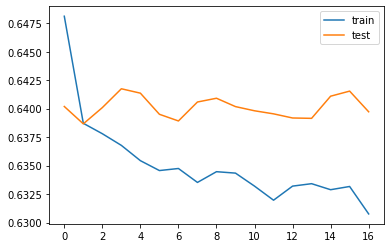

In [19]:
#from tensorflow.keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

model_mlp = Sequential()

early_stopping = EarlyStopping(monitor='val_loss', patience = 15, min_delta=0.001)

#train_rf_X = np.reshape(train_rf_X, (train_rf_X.shape[0], train_rf_X.shape[1], train_rf_X.shape[2]))

#train_rf_y = np.reshape(train_rf_y, (train_rf_y.shape[0],1))

model_mlp.add(Dense(1000, input_shape=(train_rf_X.shape[1],), activation = 'relu'))
model_mlp.add(Dropout(0.3))

#Additional layers we researched and then didn't use due to poor performance
model_mlp.add(Dense(1000, activation = 'relu'))
model_mlp.add(Dropout(0.3))

model_mlp.add(Dense(1000, activation = 'relu'))
model_mlp.add(Dropout(0.3))

model_mlp.add(Dense(units = 1, activation = 'sigmoid'))

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [tf.keras.metrics.Recall()])
model_mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics = 'accuracy')
# fit network
history_mlp = model_mlp.fit(train_rf_X, train_rf_y, epochs = 100, batch_size=32, validation_data = (test_rf_X, test_rf_y), verbose=2, shuffle=False, callbacks=[early_stopping])

# plot history
plt.plot(history_mlp.history['loss'], label='train')
plt.plot(history_mlp.history['val_loss'], label='test')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

yhat_mlp = (model_mlp.predict(test_rf_X) > 0.5).astype("int32")

yhat_mlp = yhat_mlp.reshape(yhat_mlp.shape[0],yhat_mlp.shape[1])

test_rf_y = test_rf_y.reshape(test_rf_y.shape[0],1)

print(confusion_matrix(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(yhat_mlp).iloc[:,0]))
#print('Classification Report')
#target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(yhat_mlp).iloc[:,0], target_names = ['0', '1']))

#print(yhat, validation_y)

[[1275  952]
 [ 682 1763]]
              precision    recall  f1-score   support

           0       0.65      0.57      0.61      2227
           1       0.65      0.72      0.68      2445

    accuracy                           0.65      4672
   macro avg       0.65      0.65      0.65      4672
weighted avg       0.65      0.65      0.65      4672



In [ ]:
# Model 2 Development

validation_rf_X = validation_X[:,0,1:]

validation_rf_y = validation_y[:,0,0]

(18312,)